In [1]:
import qlib
import pandas as pd
from qlib.constant import REG_CN
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
provider_uri = "/home/ubuntu/myquant/qbin"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
market = "all"
benchmark = "000001"

[3413:MainThread](2022-04-07 00:34:11,825) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[3413:MainThread](2022-04-07 00:34:11,829) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[3413:MainThread](2022-04-07 00:34:11,829) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/data/wwwroot/Notebook/qbin')}


In [2]:
###################################
# train model
###################################
import sys

data_handler_config = {
    "start_time": "2015-01-01",
    "end_time": "2022-03-30",
    "fit_start_time": "2015-01-01",
    "fit_end_time": "2020-12-31",
    "instruments": market,
}

task = {
    "model": {
        "class": "LGBModel",
        "module_path": "dart",
        "kwargs": {
            "colsample_bytree": 0.8879,
            "num_threads": 20,
        },
    },
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "finhackalpha",
                "module_path": 'finhackalpha.py',
                "kwargs": data_handler_config,
            },
            "segments": {
                "train": ("2015-01-01", "2018-12-31"),
                "valid": ("2019-01-01", "2019-12-31"),
                "test": ("2020-01-01", "2022-03-30"),
            },
        },
    },
}

# model initiaiton
model = init_instance_by_config(task["model"])
dataset = init_instance_by_config(task["dataset"])

# start exp to train model
with R.start(experiment_name="train_model"):
    R.log_params(**flatten_dict(task))
    model.fit(dataset)
    R.save_objects(trained_model=model)
    rid = R.get_recorder().id

total alphas:82


[3413:MainThread](2022-04-07 00:34:26,379) INFO - qlib.timer - [log.py:113] - Time cost: 14.466s | Loading data Done
[3413:MainThread](2022-04-07 00:34:26,381) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | fit & process data Done
[3413:MainThread](2022-04-07 00:34:26,382) INFO - qlib.timer - [log.py:113] - Time cost: 14.469s | Init data Done
[3413:MainThread](2022-04-07 00:34:26,383) INFO - qlib.workflow - [expm.py:315] - <mlflow.tracking.client.MlflowClient object at 0x7ff4125ebd00>
[3413:MainThread](2022-04-07 00:34:26,398) INFO - qlib.workflow - [exp.py:257] - Experiment 1 starts running ...
[3413:MainThread](2022-04-07 00:34:26,473) INFO - qlib.workflow - [recorder.py:293] - Recorder 66d14a16cd3e44508a175c4941bea2f4 starts running under Experiment 1 ...


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8879 will be ignored. Current value: feature_fraction=0.7


/data/anaconda3/envs/finhack/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	train's ds: 1.59969	valid's ds: 0.781461
[40]	train's ds: 1.67006	valid's ds: 0.810333
[60]	train's ds: 6.59678	valid's ds: 1.22697
[80]	train's ds: 1.82455	valid's ds: 0.917763
[100]	train's ds: 7.02226	valid's ds: 0.940259
[120]	train's ds: 1.63951	valid's ds: 0.925489
[140]	train's ds: 1.9075	valid's ds: 1.04005
[160]	train's ds: 1.45737	valid's ds: 1.14994
[180]	train's ds: 1.33496	valid's ds: 0.92214
[200]	train's ds: 1.90145	valid's ds: 0.854898
[220]	train's ds: 1.66614	valid's ds: 0.858837
[240]	train's ds: 2.07136	valid's ds: 0.808073
[260]	train's ds: 2.51868	valid's ds: 0.821149
[280]	train's ds: 3.77852	valid's ds: 0.844072
[300]	train's ds: 3.0437	valid's ds: 0.845791
[320]	train's ds: 1.35451	valid's ds: 0.820589
[340]	train's ds: 1.22161	valid's ds: 0.902011
[360]	train's ds: 1.19748	valid's ds: 0.853143
[380]	train's ds: 1.53622	valid's ds: 0.847835
[400]	train's ds: 1.51565	valid's ds: 0.817013
[420]	train's ds: 1.13952	valid's ds: 0.845709
[440]	train's ds: 1.119

[3413:MainThread](2022-04-07 00:38:18,041) INFO - qlib.timer - [log.py:113] - Time cost: 1.301s | waiting `async_log` Done


In [7]:
###################################
# prediction, backtest & analysis
###################################
port_analysis_config = {
    "executor": {
        "class": "SimulatorExecutor",
        "module_path": "qlib.backtest.executor",
        "kwargs": {
            "time_per_step": "day",
            "generate_portfolio_metrics": True,
        },
    },
    "strategy": {
        "class": "TopkDropoutStrategy",
        "module_path": "qlib.contrib.strategy.signal_strategy",
        "kwargs": {
            "model": model,
            "dataset": dataset,
            "topk": 10,
            "n_drop": 10,
        },
    },
    "backtest": {
        "start_time": "2020-01-01",
        "end_time": "2022-03-01",
        "account": 1000000,
        "benchmark": benchmark,
        "exchange_kwargs": {
            "freq": "day",
            "limit_threshold": 0.095,
            "deal_price": "close",
            "open_cost": 0.0005,
            "close_cost": 0.0015,
            "min_cost": 5,
        },
    },
}

# backtest and analysis
with R.start(experiment_name="backtest_analysis"):
    recorder = R.get_recorder(recorder_id=rid, experiment_name="train_model")
    model = recorder.load_object("trained_model")

    # prediction
    recorder = R.get_recorder()
    ba_rid = recorder.id
    sr = SignalRecord(model, dataset, recorder)
    sr.generate()

    # backtest & analysis
    par = PortAnaRecord(recorder, port_analysis_config, "day")
    par.generate()


[3413:MainThread](2022-04-07 00:39:55,369) INFO - qlib.workflow - [expm.py:315] - <mlflow.tracking.client.MlflowClient object at 0x7ff3f391c400>
[3413:MainThread](2022-04-07 00:39:55,372) INFO - qlib.workflow - [exp.py:257] - Experiment 2 starts running ...
[3413:MainThread](2022-04-07 00:39:55,380) INFO - qlib.workflow - [recorder.py:293] - Recorder fe17bcb11ecb41e2946ec79860c104e9 starts running under Experiment 2 ...
[3413:MainThread](2022-04-07 00:39:59,051) INFO - qlib.workflow - [record_temp.py:194] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 2
[3413:MainThread](2022-04-07 00:39:59,089) INFO - qlib.backtest caller - [__init__.py:83] - Create new exchange


'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2020-01-02 000001      0.886475
           000002      0.712769
           000063      0.753971
           000066      0.847976
           000069      0.882292


[3413:MainThread](2022-04-07 00:40:04,439) WARNING - qlib.BaseExecutor - [executor.py:111] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7ff3f2e39640>


backtest loop:   0%|          | 0/522 [00:00<?, ?it/s]

[3413:MainThread](2022-04-07 00:40:09,856) INFO - qlib.workflow - [record_temp.py:499] - Portfolio analysis record 'port_analysis_1day.pkl' has been saved as the artifact of the Experiment 2
[3413:MainThread](2022-04-07 00:40:09,866) INFO - qlib.workflow - [record_temp.py:524] - Indicator analysis record 'indicator_analysis_1day.pkl' has been saved as the artifact of the Experiment 2
[3413:MainThread](2022-04-07 00:40:09,884) INFO - qlib.timer - [log.py:113] - Time cost: 0.006s | waiting `async_log` Done


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000254
std                0.023289
annualized_return  0.060415
information_ratio  0.168149
max_drawdown      -0.417922
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean               0.003011
std                0.021812
annualized_return  0.716609
information_ratio  2.129574
max_drawdown      -0.478922
'The following are analysis results of the excess return with cost(1day).'
                       risk
mean               0.002278
std                0.021820
annualized_return  0.542100
information_ratio  1.610400
max_drawdown      -0.627167
'The following are analysis results of indicators(1day).'
     value
ffr    1.0
pa     0.0
pos    0.0


In [8]:
from qlib.contrib.report import analysis_model, analysis_position
from qlib.data import D
recorder = R.get_recorder(recorder_id=ba_rid, experiment_name="backtest_analysis")
print(recorder)
pred_df = recorder.load_object("pred.pkl")
pred_df_dates = pred_df.index.get_level_values(level='datetime')
report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")
positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")
analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")


{'class': 'Recorder', 'id': 'fe17bcb11ecb41e2946ec79860c104e9', 'name': 'mlflow_recorder', 'experiment_id': '2', 'start_time': '2022-04-07 00:39:55', 'end_time': '2022-04-07 00:40:09', 'status': 'FINISHED'}


In [11]:
import akshare as ak
hs300 = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20200102", end_date="20220301")    
hs300['return']=hs300['收盘'].shift(1)/hs300['收盘']-1
hs300.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                       '最高':'high', '最低':'low', '成交量':'volume',
                       '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
                       '涨跌额':'chg_amount', '换手率':'turnover',
                      }, inplace = True)
hs300['date'] = pd.to_datetime(hs300['date'], format='%Y-%m-%d')
hs300=hs300.set_index('date') 

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-01-02  2020-01-02
End Period                 2022-03-01  2022-03-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          416.52%     -10.28%
CAGR﹪                     113.74%     -4.89%

Sharpe                     3.42        -0.15
Smart Sharpe               2.92        -0.13
Sortino                    5.6         -0.23
Smart Sortino              4.77        -0.19
Sortino/√2                 3.96        -0.16
Smart Sortino/√2           3.37        -0.14
Omega                      1.81        1.81

Max Drawdown               -14.01%     -39.21%
Longest DD Days            101         707
Volatility (ann.)          24.03%      20.68%
R^2                        0.55        0.55
Calmar                     8.12        -0.12
Skew                       -0.31       0.83
Kurtosis                   4.45 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-22,2021-03-09,2021-06-03,101,-14.007918,-11.666492
2,2020-01-21,2020-02-03,2020-02-17,27,-13.938957,-12.089426
3,2020-03-16,2020-03-23,2020-04-17,32,-9.885964,-8.613395
4,2020-07-14,2020-07-17,2020-08-17,34,-8.466392,-7.194148
5,2022-01-21,2022-02-24,2022-03-01,39,-7.951159,-7.389814


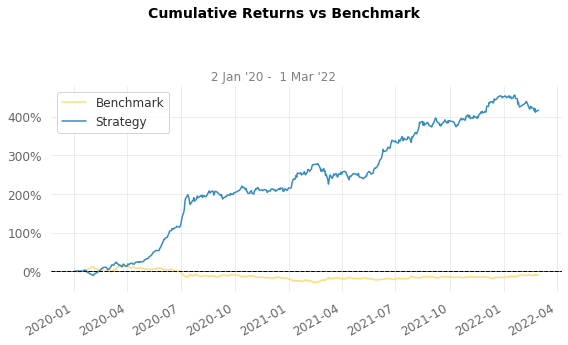

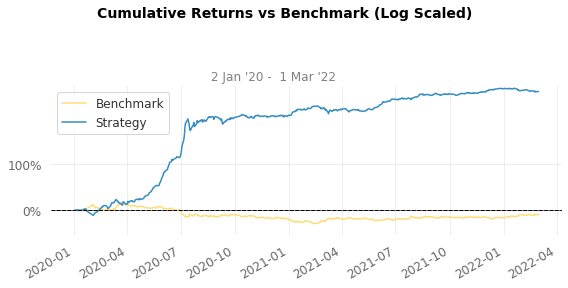

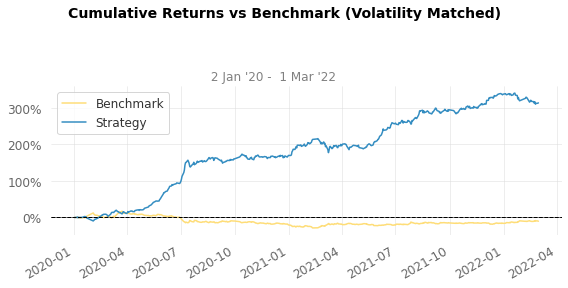

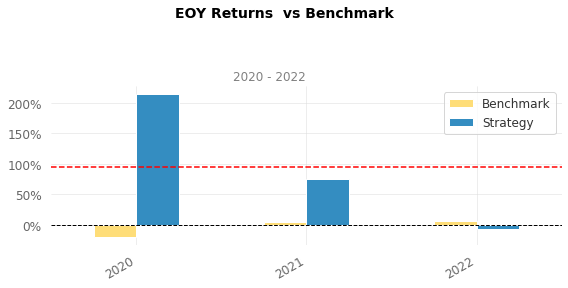

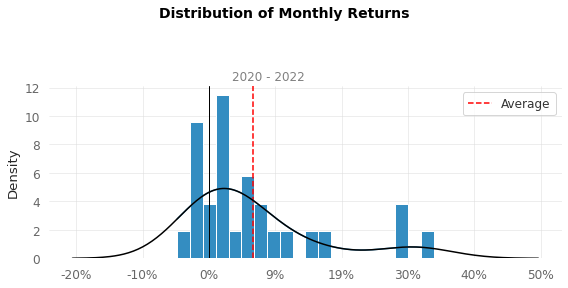

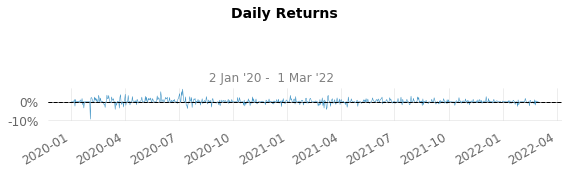

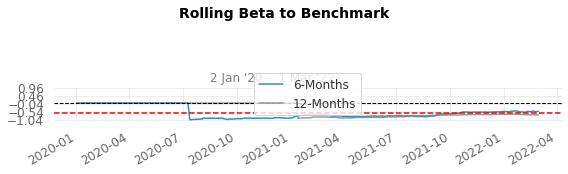

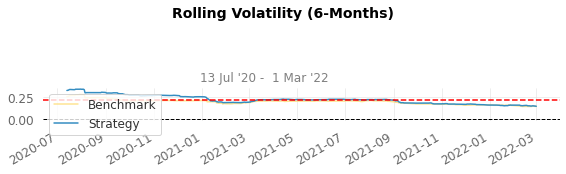

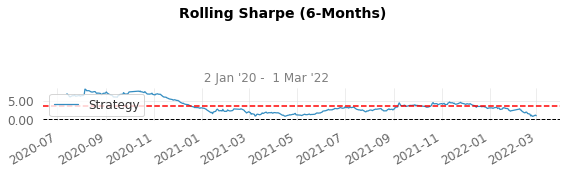

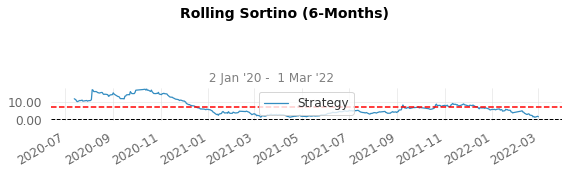

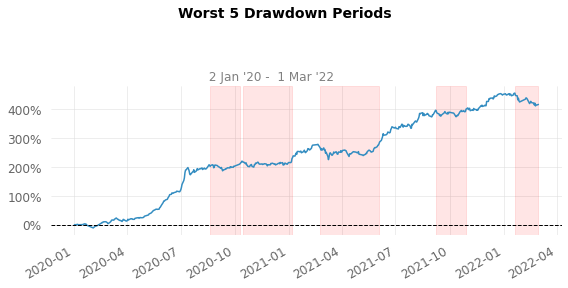

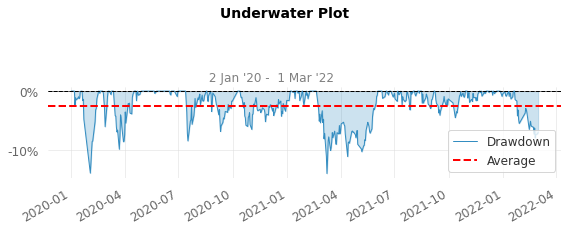

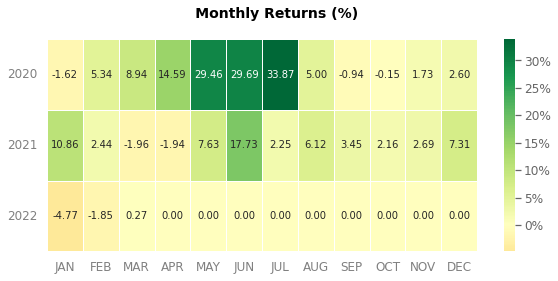

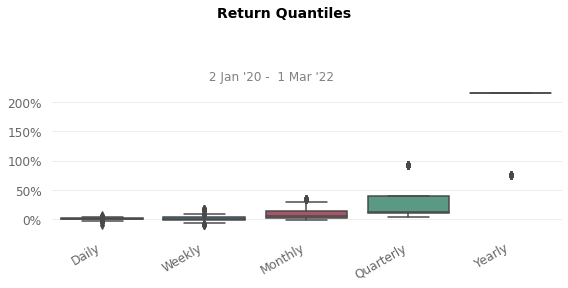

In [10]:
import quantstats as qs
qs.extend_pandas()
qs.reports.full(report_normal_df['return'], benchmark=hs300['return'])